## process scATAC data and get gene activities

In [1]:
suppressMessages({library(Signac)
library(Seurat)
library(ggplot2)
library(patchwork)
library(hdf5r)
library(SeuratData)
library(EnsDb.Hsapiens.v86)
library(ggplot2)
library(cowplot)
library(GenomeInfoDb)
library(stringr)
library(patchwork)
library(SeuratDisk)
library(dplyr)})

In [2]:
input_dir = "/project/scATAC_analysis/scATAcat_notebooks_for_paper/jan2024/results/Fig1_Fig2_Fig3_SFig1-FACS_BM_scATAC/Fig3-apply_seurat_label_transfer/01_prepare_input_files/"

In [3]:
counts <- Read10X_h5(filename = paste(input_dir ,"scATAC_BM_Corces2018_ENCODE_coverage_per_cell_matrix_nonZero.h5", sep=''))

In [4]:
any(is.na((counts)))

[1] FALSE

In [5]:
NCOL(counts)

[1] 2182

In [6]:
#counts <- Read10X_h5(filename = "../vignette_data/atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5")
metadata <- read.csv(
  file =  paste(input_dir ,"singlecell.csv", sep=''),
  header = TRUE,
  row.names = 1
)


In [7]:
chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c("_", "_"),
  fragments =paste(input_dir ,"Corces2018_BM_FACS_scATAC_fragments_reorganized_tab_sorted.sort.bed.gz", sep=''),
  min.cells = 10,
  min.features = 200
)


Warning message in CreateChromatinAssay(counts = counts, sep = c("_", "_"), fragments = paste(input_dir, :
"Overlapping ranges supplied. Ranges should be non-overlapping."
Computing hash



In [8]:
chrom_assay

ChromatinAssay data with 267309 features for 2020 cells
Variable features: 0 
Genome: 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 1 

In [9]:

bm <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata
)

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks to peaks_"


In [10]:
bm[['peaks']]

ChromatinAssay data with 267309 features for 2020 cells
Variable features: 0 
Genome: 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 1 

In [11]:
# add gene annotation information
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
ucsc.levels <- str_replace(string=paste("chr",seqlevels(annotations),sep=""), pattern="chrMT", replacement="chrM")
seqlevels(annotations) <- ucsc.levels
genome(annotations) <- "hg38"
Annotation(bm) <- annotations



Warning message:
"no function found corresponding to methods exports from 'BSgenome' for: 'releaseName'"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .Seqinfo.mergexy(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppre

In [12]:
Annotation(bm) <- annotations

In [13]:
# compute nucleosome signal score per cell
bm <- NucleosomeSignal(object = bm)

# compute TSS enrichment score per cell
bm <- TSSEnrichment(object = bm, fast = FALSE)


Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



In [14]:
#Signac::DensityScatter(bm, x = 'nCount_peaks', y = 'TSS.enrichment', log_x = TRUE, quantiles = TRUE)

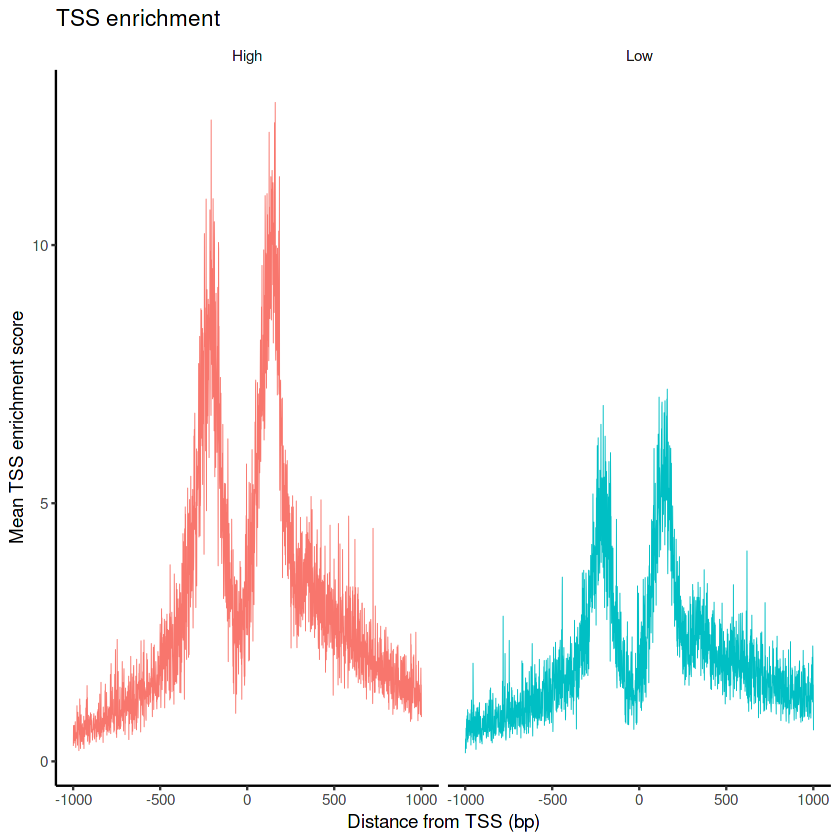

In [15]:
bm$high.tss <- ifelse(bm$TSS.enrichment > 3, 'High', 'Low')
TSSPlot(bm, group.by = 'high.tss') + NoLegend()

In [16]:
head(bm@meta.data)

,orig.ident,nCount_peaks,nFeature_peaks,is_cell,atac_fragments,nucleosome_signal,nucleosome_percentile,TSS.enrichment,TSS.percentile,high.tss
,<fct>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CLP_0,CLP,708,422,1,743,Inf,1,7.215007,0.99,High
CLP_1,CLP,2676,1422,1,2822,Inf,1,4.999083,0.75,High
CMP_0,CMP,5650,2982,1,5954,Inf,1,5.832143,0.94,High
CMP_1,CMP,7369,3891,1,7741,Inf,1,5.094905,0.78,High
CMP_2,CMP,7947,4223,1,8643,Inf,1,5.307090,0.85,High
CMP_3,CMP,8601,4548,1,9309,Inf,1,4.478280,0.48,High


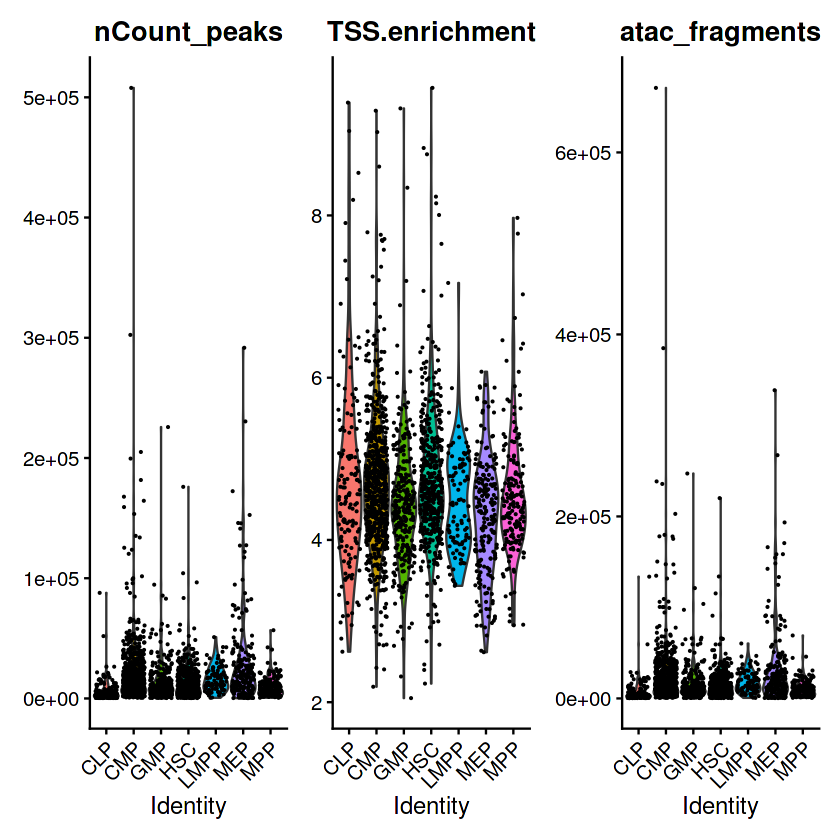

In [17]:
VlnPlot(
  object = bm,
  features = c('nCount_peaks', 'TSS.enrichment', 'atac_fragments'),
  pt.size = 0.1,
  ncol = 3
)

In [18]:
bm

An object of class Seurat 
267309 features across 2020 samples within 1 assay 
Active assay: peaks (267309 features, 0 variable features)

In [19]:
bm_filt <- subset(
  x = bm,
  subset = nCount_peaks > 300 &
    nCount_peaks < 300000 
)
bm_filt

An object of class Seurat 
267309 features across 2017 samples within 1 assay 
Active assay: peaks (267309 features, 0 variable features)

In [20]:
bm_filt <- RunTFIDF(bm_filt)
bm_filt <- FindTopFeatures(bm_filt, min.cutoff = 'q0')
bm_filt <- RunSVD(bm_filt)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



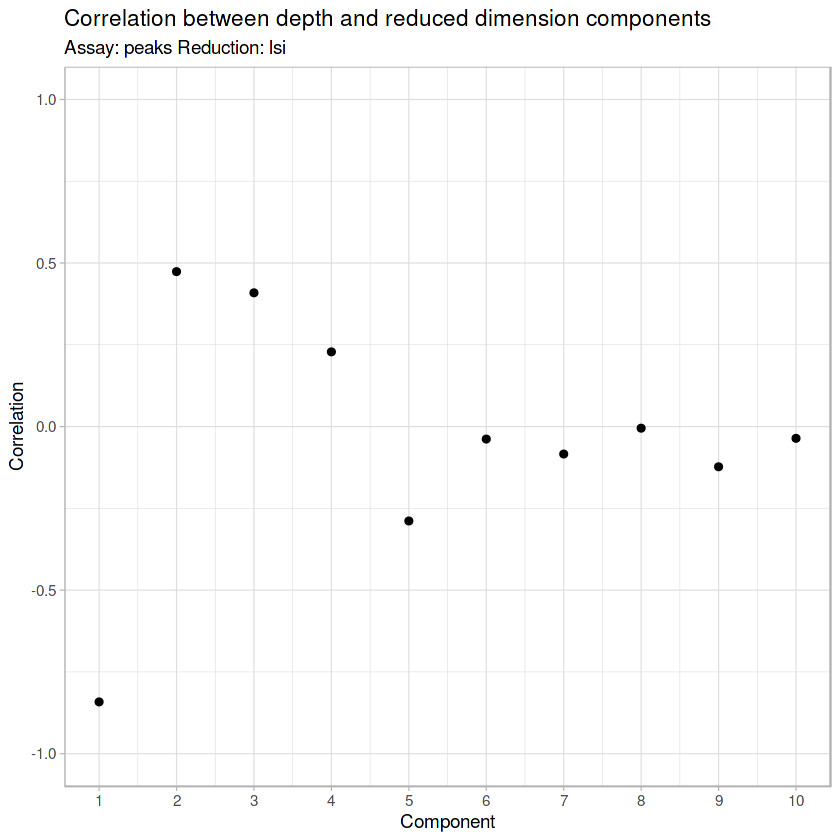

In [21]:
DepthCor(bm_filt)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
22:12:07 UMAP embedding parameters a = 0.9922 b = 1.112

22:12:07 Read 2017 rows and found 29 numeric columns

22:12:07 Using Annoy for neighbor search, n_neighbors = 30

22:12:07 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:12:07 Writing NN index file to temp file /scratch/local/RtmplD2Ktb/file1838e7eafaa8f

22:12:07 Searching Annoy index using 1 thread, search_k = 3000

22:12:07 Annoy recall = 100%

22:12:10 Commencing smooth kNN distance calibration using 1 thread
 with target n_

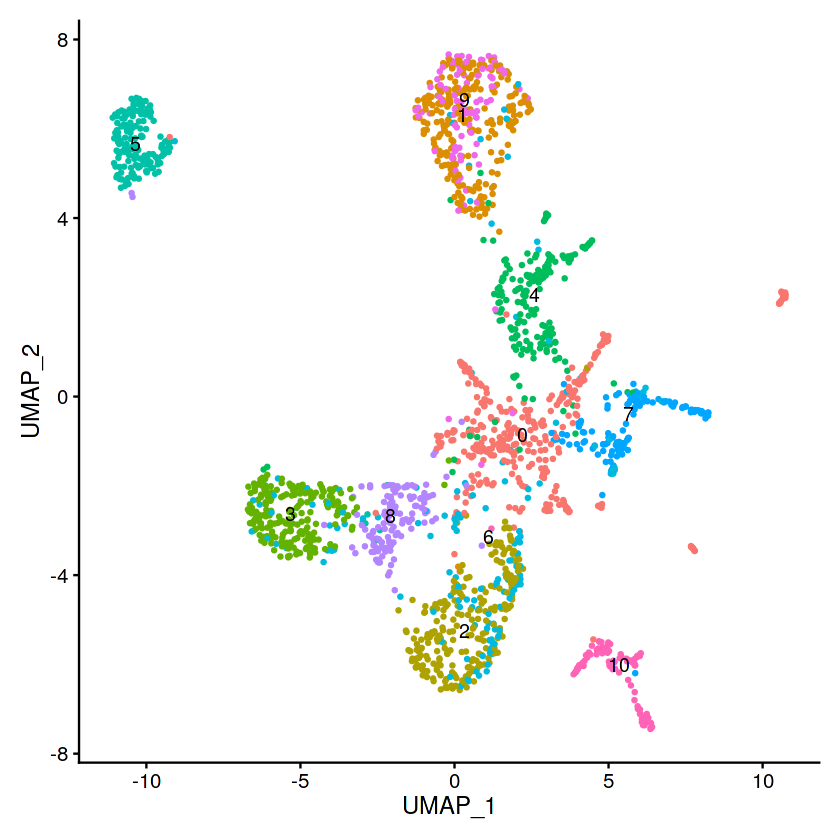

In [22]:
bm_filt <- RunUMAP(object = bm_filt, reduction = 'lsi', dims = 2:30)
bm_filt <- FindNeighbors(object = bm_filt, reduction = 'lsi', dims = 2:30)
bm_filt <- FindClusters(object = bm_filt, verbose = FALSE, algorithm = 3)
DimPlot(object = bm_filt, label = TRUE) + NoLegend()

In [23]:
gene.activities <- GeneActivity(bm_filt)

Extracting gene coordinates

Extracting reads overlapping genomic regions



In [24]:
# add the gene activity matrix to the Seurat object as a new assay and normalize it
bm_filt[['RNA']] <- CreateAssayObject(counts = gene.activities)
bm_filt <- NormalizeData(
  object = bm_filt,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(bm_filt$nCount_RNA)
)

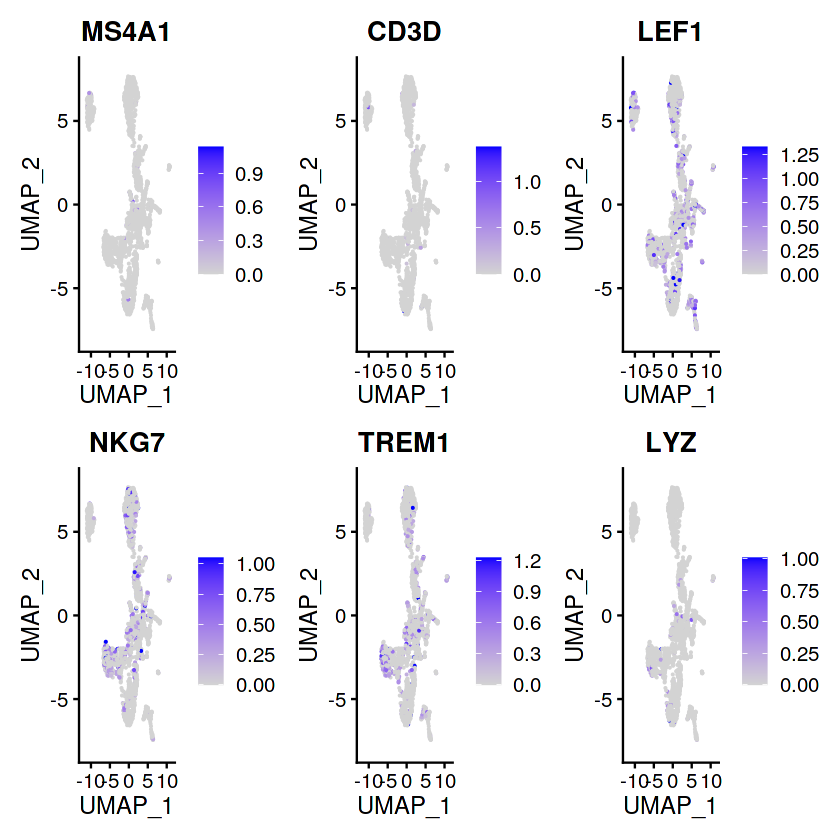

In [25]:
DefaultAssay(bm_filt) <- 'RNA'

FeaturePlot(
  object = bm_filt,
  features = c('MS4A1', 'CD3D', 'LEF1', 'NKG7', 'TREM1', 'LYZ'),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 3
)

## apply label transfer using bm CITE-seq data

In [26]:
# load reference data
bm_ref <- LoadData(ds = "bmcite")


In [28]:
head(bm_ref@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,lane,donor,celltype.l1,celltype.l2,RNA.weight
,<chr>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
a_AAACCTGAGCTTATCG-1,bmcite,7546,2136,1350,25,HumanHTO4,batch1,Progenitor cells,Prog_RBC,0.4827011
a_AAACCTGAGGTGGGTT-1,bmcite,1029,437,2970,25,HumanHTO1,batch1,T cell,gdT,0.2417890
a_AAACCTGAGTACATGA-1,bmcite,1111,429,2474,23,HumanHTO5,batch1,T cell,CD4 Naive,0.5077136
a_AAACCTGCAAACCTAC-1,bmcite,2741,851,4799,25,HumanHTO3,batch1,T cell,CD4 Memory,0.4313079
a_AAACCTGCAAGGTGTG-1,bmcite,2099,843,5434,25,HumanHTO2,batch1,Mono/DC,CD14 Mono,0.5685085
a_AAACCTGCACGGTAGA-1,bmcite,2291,783,4658,25,HumanHTO6,batch1,B cell,Naive B,0.4255879


### subset the reference only to progenitors

In [33]:
bm_ref_ony_progenitor <- subset(x = bm_ref, subset = celltype.l1 == "Progenitor cells")

In [34]:
bm_ref_ony_progenitor@assays


$RNA
Assay data with 17009 features for 2879 cells
Top 10 variable features:
 IGKC, HBA2, HBB, HBA1, IGHA1, IGLC2, JCHAIN, HBM, IGHG1, IGHM 

$ADT
Assay data with 25 features for 2879 cells
Top 10 variable features:
 CD11a, CD11c, CD123, CD127-IL7Ra, CD14, CD16, CD161, CD19, CD197-CCR7,
CD25 


In [35]:
# process the small data again

DefaultAssay(bm_ref_ony_progenitor) <- 'RNA'
bm_ref_ony_progenitor <- NormalizeData(bm_ref_ony_progenitor) %>% FindVariableFeatures() %>% ScaleData() %>% RunPCA()

DefaultAssay(bm_ref_ony_progenitor) <- 'ADT'
# we will use all ADT features for dimensional reduction
# we set a dimensional reduction name to avoid overwriting the 
VariableFeatures(bm_ref_ony_progenitor) <- rownames(bm_ref_ony_progenitor[["ADT"]])
bm_ref_ony_progenitor <- NormalizeData(bm_ref_ony_progenitor, normalization.method = 'CLR', margin = 2) %>% 
  ScaleData() %>% RunPCA(reduction.name = 'apca')

Centering and scaling data matrix

PC_ 1 
Positive:  TMSB4X, VIM, ACTG1, HLA-DRA, CD74, LYZ, LGALS1, SH3BGRL3, SRGN, S100A9 
	   S100A8, TYROBP, FOS, RNASE2, CSTA, MNDA, CORO1A, PKM, ANXA1, PLAC8 
	   HLA-DPB1, COTL1, RETN, HLA-DRB5, ANXA2, VCAN, S100A10, HLA-DRB1, MPO, FCN1 
Negative:  KCNH2, FAM178B, KLF1, PRDX2, CA1, SMIM1, EPCAM, REXO2, MPC2, GATA1 
	   APOC1, AHSP, ATPIF1, NME4, CNRIP1, UBAC1, TFR2, BLVRB, SYNGR1, LMNA 
	   UROD, TMEM14C, HES6, NFIA, RFESD, TMEM56, TSPAN17, HEBP1, GLRX5, EPOR 
PC_ 2 
Positive:  HBM, SLC4A1, HBA2, GYPB, GYPA, HBA1, ALAS2, HBD, HEMGN, HBB 
	   SLC25A37, TSPO2, RHCE, SELENBP1, AHSP, CA2, RHAG, DMTN, SOX6, EPB42 
	   HMBS, GYPE, CA1, AQP1, SNCA, SLC2A1, MGST3, ACKR1, RGCC, MYL4 
Negative:  NPM1, EEF1B2, RPL14, RPL4, STMN1, FABP5, PEBP1, LDHA, HSP90AB1, ACTG1 
	   MIF, HMGA1, PFN1, C1QBP, SOX4, NCL, SRM, CD74, MARCKSL1, HSPD1 
	   PRSS57, IGFBP7, IGLL1, GTF3A, CDK4, NME1, HSPE1, NAA38, RANBP1, ATP5G3 
PC_ 3 
Positive:  KIAA0125, SPINK2, EGFL7, HOPX, PR

In [36]:
# Identify multimodal neighbors. These will be stored in the neighbors slot, 
# and can be accessed using bm[['weighted.nn']]
# The WNN graph can be accessed at bm[["wknn"]], 
# and the SNN graph used for clustering at bm[["wsnn"]]
# Cell-specific modality weights can be accessed at bm$RNA.weight
bm_ref_ony_progenitor <- FindMultiModalNeighbors(
  bm_ref_ony_progenitor, reduction.list = list("pca", "apca"), 
  dims.list = list(1:30, 1:18), modality.weight.name = "RNA.weight"
)

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Warning message in FindMultiModalNeighbors(bm_ref_ony_progenitor, reduction.list = list("pca", :
"The number of provided modality.weight.name is not equal to the number of modalities. RNA.weight ADT.weight are used to store the modality weights"
Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph



UMAP will return its model

22:20:02 UMAP embedding parameters a = 0.9922 b = 1.112

22:20:05 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

22:20:06 Initializing from normalized Laplacian + noise (using irlba)

22:20:07 Commencing optimization for 500 epochs, with 83944 positive edges

22:20:12 Optimization finished

22:20:12 Note: model requested with precomputed neighbors. For transforming new data, distance data must be provided separately



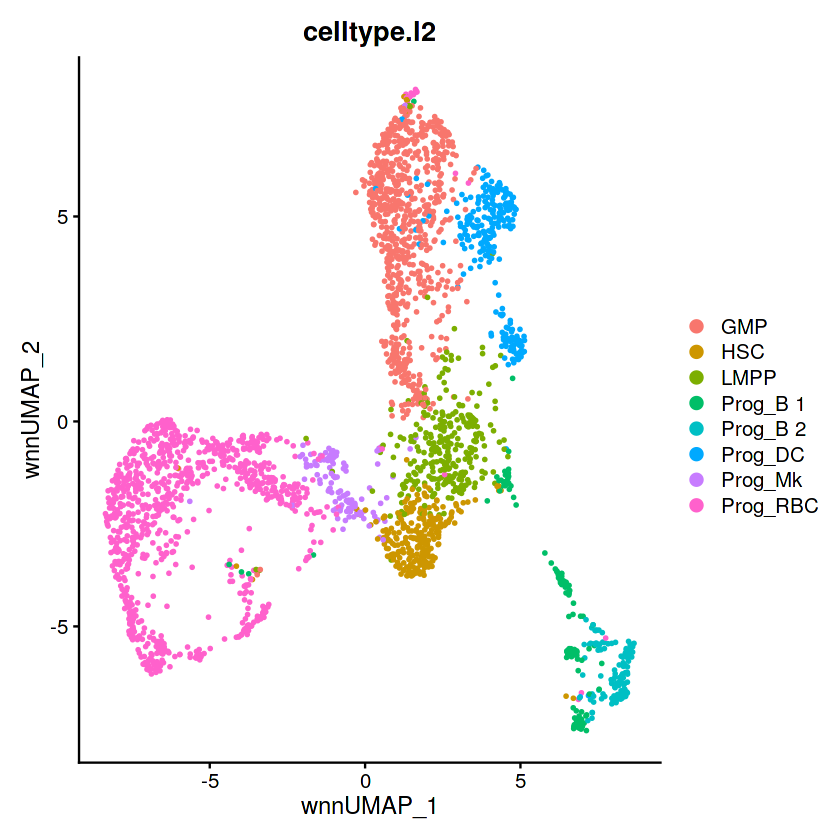

In [37]:
bm_ref_ony_progenitor <- RunUMAP(bm_ref_ony_progenitor, nn.name = "weighted.nn", reduction.name = "wnn.umap", 
              reduction.key = "wnnUMAP_", return.model = TRUE)
DimPlot(bm_ref_ony_progenitor, group.by = "celltype.l2", reduction = "wnn.umap") 

In [38]:
bm_ref_ony_progenitor <- ScaleData(bm_ref_ony_progenitor, assay = 'RNA')
bm_ref_ony_progenitor <- RunSPCA(bm_ref_ony_progenitor, assay = 'RNA', graph = 'wsnn')

Centering and scaling data matrix

Computing sPCA transformation



### as per the guidelines, both the refernece and the query should have the same normalization method applied for label trasfer. As gene.activity matrix can only have log transformation, we should apply the same for the reference as well.

In [39]:
bm_ref_ony_progenitor

An object of class Seurat 
17034 features across 2879 samples within 2 assays 
Active assay: ADT (25 features, 25 variable features)
 1 other assay present: RNA
 4 dimensional reductions calculated: spca, pca, apca, wnn.umap

In [40]:
bm_ref_ony_progenitor_logTransformedRNA <- CreateAssayObject(counts = bm_ref_ony_progenitor@assays$RNA@counts)

In [41]:
bm_ref_ony_progenitor[["logTransformedRNA"]] <- bm_ref_ony_progenitor_logTransformedRNA

In [42]:
DefaultAssay(bm_ref_ony_progenitor) <- "logTransformedRNA"

In [43]:
bm_ref_ony_progenitor

An object of class Seurat 
34043 features across 2879 samples within 3 assays 
Active assay: logTransformedRNA (17009 features, 0 variable features)
 2 other assays present: RNA, ADT
 4 dimensional reductions calculated: spca, pca, apca, wnn.umap

In [44]:
bm_ref_ony_progenitor <- NormalizeData(
  bm_ref_ony_progenitor,
  normalization.method = "LogNormalize")

In [45]:
bm_ref_ony_progenitor@assays$logTransformedRNA

Assay data with 17009 features for 2879 cells
First 10 features:
 FO538757.2, AP006222.2, RP4-669L17.10, RP11-206L10.9, LINC00115,
FAM41C, SAMD11, NOC2L, KLHL17, PLEKHN1 

In [46]:
bm_ref_ony_progenitor <- FindVariableFeatures(bm_ref_ony_progenitor)
bm_ref_ony_progenitor <- ScaleData(bm_ref_ony_progenitor)
bm_ref_ony_progenitor <- RunPCA(bm_ref_ony_progenitor)
bm_ref_ony_progenitor <- RunUMAP(bm_ref_ony_progenitor, dims = 1:30)


Centering and scaling data matrix

PC_ 1 
Positive:  TMSB4X, VIM, ACTG1, HLA-DRA, CD74, LYZ, LGALS1, SH3BGRL3, SRGN, S100A9 
	   S100A8, TYROBP, FOS, RNASE2, CSTA, MNDA, CORO1A, PKM, ANXA1, PLAC8 
	   HLA-DPB1, COTL1, RETN, HLA-DRB5, ANXA2, VCAN, S100A10, HLA-DRB1, MPO, FCN1 
Negative:  KCNH2, FAM178B, KLF1, PRDX2, CA1, SMIM1, EPCAM, REXO2, MPC2, GATA1 
	   APOC1, AHSP, ATPIF1, NME4, CNRIP1, UBAC1, TFR2, BLVRB, SYNGR1, LMNA 
	   UROD, TMEM14C, HES6, NFIA, RFESD, TMEM56, TSPAN17, HEBP1, GLRX5, EPOR 
PC_ 2 
Positive:  HBM, SLC4A1, HBA2, GYPB, GYPA, HBA1, ALAS2, HBD, HEMGN, HBB 
	   SLC25A37, TSPO2, RHCE, SELENBP1, AHSP, CA2, RHAG, DMTN, SOX6, EPB42 
	   HMBS, GYPE, CA1, AQP1, SNCA, SLC2A1, MGST3, ACKR1, RGCC, MYL4 
Negative:  NPM1, EEF1B2, RPL14, RPL4, STMN1, FABP5, PEBP1, LDHA, HSP90AB1, ACTG1 
	   MIF, HMGA1, PFN1, C1QBP, SOX4, NCL, SRM, CD74, MARCKSL1, HSPD1 
	   PRSS57, IGFBP7, IGLL1, GTF3A, CDK4, NME1, HSPE1, NAA38, RANBP1, ATP5G3 
PC_ 3 
Positive:  KIAA0125, SPINK2, EGFL7, HOPX, PR

In [47]:
bm_ref_ony_progenitor <- RunSPCA(bm_ref_ony_progenitor, reduction.key = "SPC_logTr_", assay = 'logTransformedRNA', graph = 'wsnn')


Computing sPCA transformation

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from SPC_logTr_ to SPClogTr_"
Warning message:
"All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to SPClogTr_"


In [48]:
bm_ref_ony_progenitor

An object of class Seurat 
34043 features across 2879 samples within 3 assays 
Active assay: logTransformedRNA (17009 features, 2000 variable features)
 2 other assays present: RNA, ADT
 5 dimensional reductions calculated: spca, pca, apca, wnn.umap, umap

In [49]:
bm_ref_ony_progenitor <- FindNeighbors(
  object = bm_ref_ony_progenitor,
  reduction = "spca",
  dims = 1:50,
  graph.name = "spca.annoy.neighbors", 
  k.param = 50,
  cache.index = TRUE,
  return.neighbor = TRUE,
  l2.norm = TRUE
)

Computing nearest neighbors

Only one graph name supplied, storing nearest-neighbor graph only



In [50]:
bm_ref_ony_progenitor

An object of class Seurat 
34043 features across 2879 samples within 3 assays 
Active assay: logTransformedRNA (17009 features, 2000 variable features)
 2 other assays present: RNA, ADT
 5 dimensional reductions calculated: spca, pca, apca, wnn.umap, umap

In [51]:
bm_ref_ony_progenitor <- RunUMAP(bm_ref_ony_progenitor, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")


22:21:54 UMAP embedding parameters a = 0.9922 b = 1.112

22:21:56 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

22:21:59 Initializing from normalized Laplacian + noise (using irlba)

22:21:59 Commencing optimization for 500 epochs, with 83944 positive edges

22:22:05 Optimization finished



In [52]:
bm_ref_ony_progenitor <- FindClusters(bm_ref_ony_progenitor, graph.name = "wsnn", algorithm = 3, resolution = 2, verbose = FALSE)

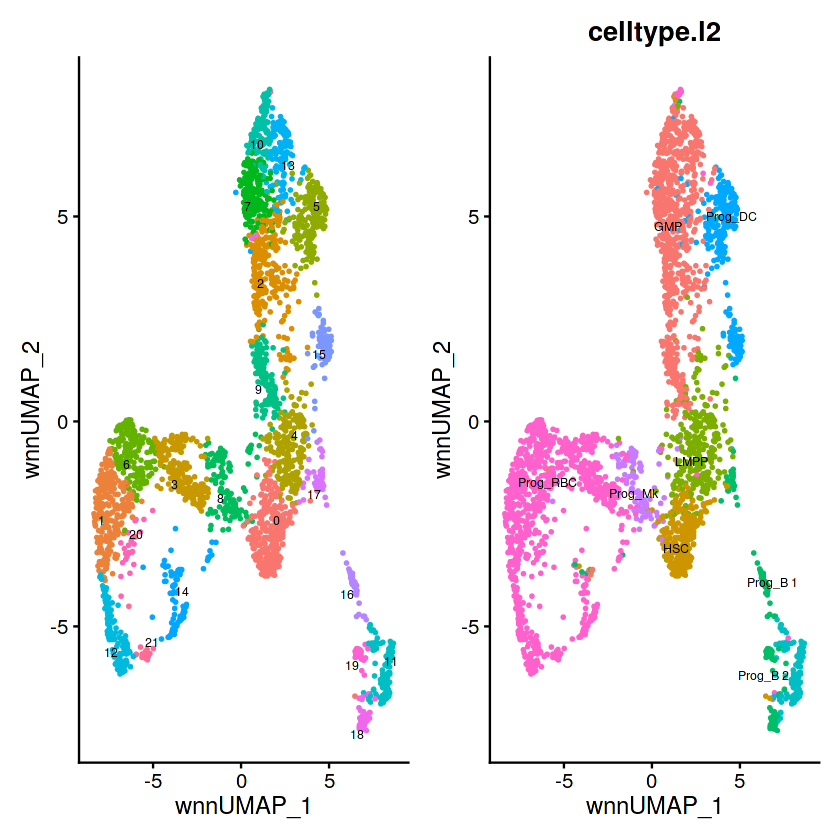

In [53]:
p1 <- DimPlot(bm_ref_ony_progenitor, reduction = 'wnn.umap', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()
p2 <- DimPlot(bm_ref_ony_progenitor, reduction = 'wnn.umap', group.by = 'celltype.l2', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()
p1 + p2

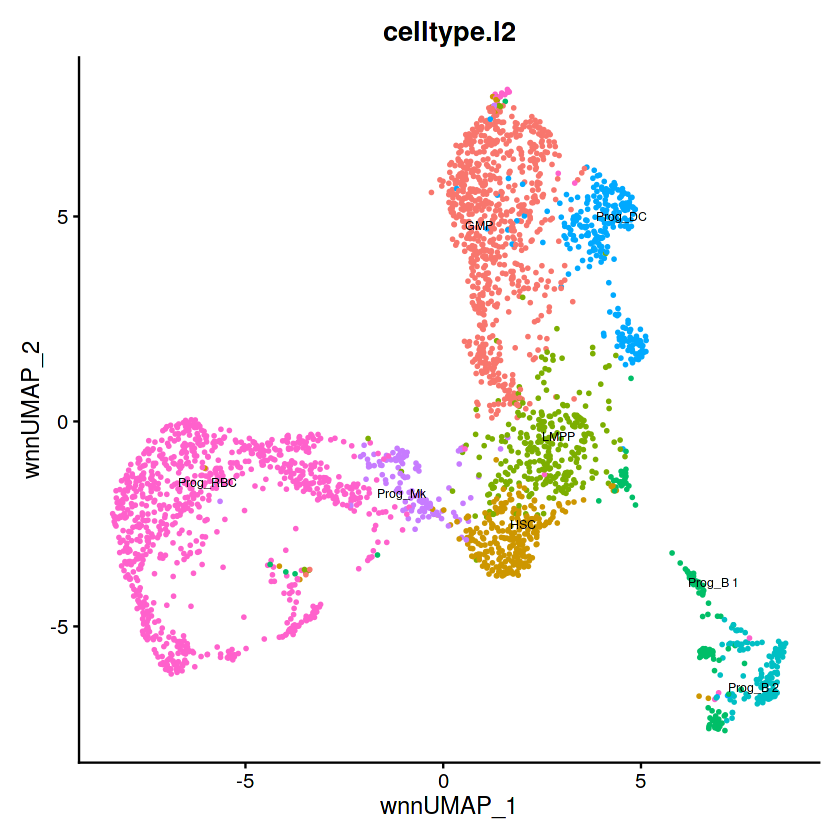

In [54]:
DimPlot(bm_ref_ony_progenitor, reduction = 'wnn.umap', group.by = 'celltype.l2', label = TRUE, repel = TRUE, label.size = 2.5) + NoLegend()


### get the variable features from gene activity object

In [55]:
bm_filt <- FindVariableFeatures(bm_filt, selection.method = "vst", nfeatures = 3000)

In [56]:
bm_filt

An object of class Seurat 
286916 features across 2017 samples within 2 assays 
Active assay: RNA (19607 features, 3000 variable features)
 1 other assay present: peaks
 2 dimensional reductions calculated: lsi, umap

## label transfer

In [53]:
bm_ref

An object of class Seurat 
34043 features across 30672 samples within 3 assays 
Active assay: logTransformedRNA (17009 features, 2000 variable features)
 2 other assays present: RNA, ADT
 4 dimensional reductions calculated: spca, wnn.umap, pca, umap

In [57]:
anchors <- FindTransferAnchors(
    reference = bm_ref_ony_progenitor,
    query = bm_filt,
    k.filter = NA,
    reference.reduction = "spca", 
    reference.neighbors = "spca.annoy.neighbors", 
    dims = 1:50,
    reference.assay = 'logTransformedRNA'
  )


Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 161 anchors



### through the standard pipeline we retained only a small number of anchors, so we will try with cca now..

In [58]:
bm.cca.anchors <- FindTransferAnchors(reference = bm_ref_ony_progenitor, query = bm_filt, reduction = 'cca', dims = 1:30, 
                               reference.assay = 'logTransformedRNA', query.assay = 'RNA', normalization.method = 'LogNormalize')


Warning message in RunCCA.Seurat(object1 = reference, object2 = query, features = features, :
"Running CCA on different assays"
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 7456 anchors

Filtering anchors

	Retained 1451 anchors



### CCA resulted in much more anchors making this approach more reliable. Therefore we will proceed with CCA

In [59]:
bm_filt <- TransferData(
  anchorset = bm.cca.anchors, 
  reference = bm_ref_ony_progenitor,
  query = bm_filt,
  refdata = list(
    celltype.l1 = "celltype.l1",
    celltype.l2 = "celltype.l2",
    predicted_ADT = "ADT"),
    weight.reduction = 'cca'
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscorecelltype.l1_ to predictionscorecelltypel1_"
Predicting cell labels

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscorecelltype.l2_ to predictionscorecelltypel2_"
Transfering 25 features onto reference data

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from predicted_ADT_ to predictedADT_"


In [60]:
bm_filt <- IntegrateEmbeddings(
  anchorset = bm.cca.anchors,
  reference = bm_ref_ony_progenitor,
  query = bm_filt, 
  new.reduction.name = "ref.cca",
  reductions = "cca",
)


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data



### export outputs and figures

In [61]:
saveRDS(file='../../../results/Fig1_Fig2_Fig3_SFig1-FACS_BM_scATAC/Fig3-apply_seurat_label_transfer/WS/bm_filt.RDS', bm_filt)

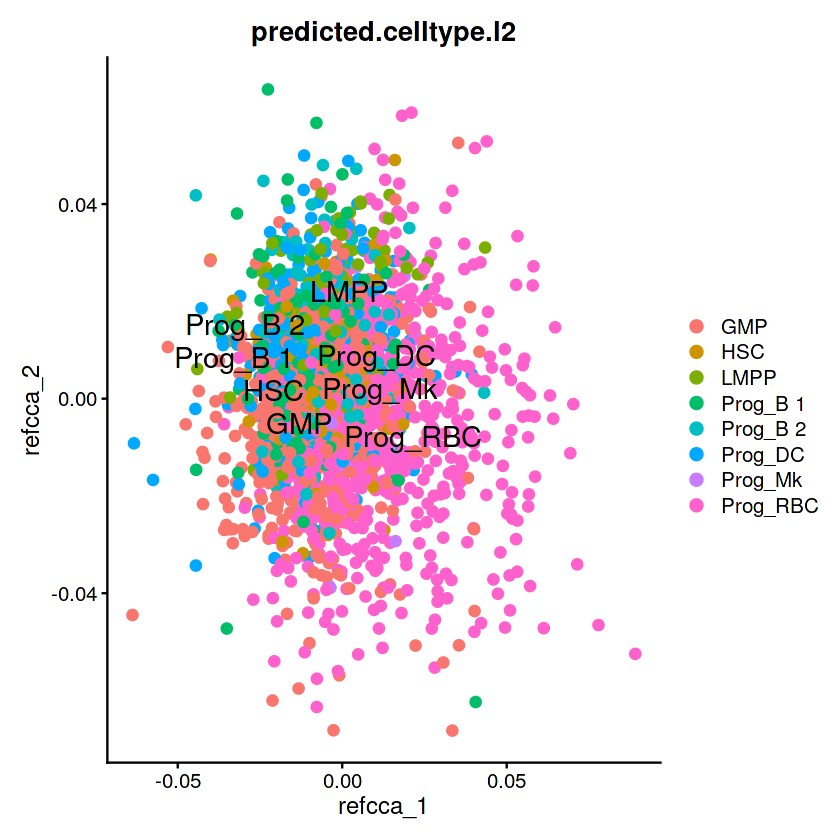

In [62]:
DimPlot(bm_filt, reduction = "ref.cca", group.by = "predicted.celltype.l2", label = TRUE, label.size = 6 ,repel = TRUE, pt.size = 2.5)


In [63]:
figures_dir = "../../../results/Fig1_Fig2_Fig3_SFig1-FACS_BM_scATAC/Fig3-apply_seurat_label_transfer/figures/"

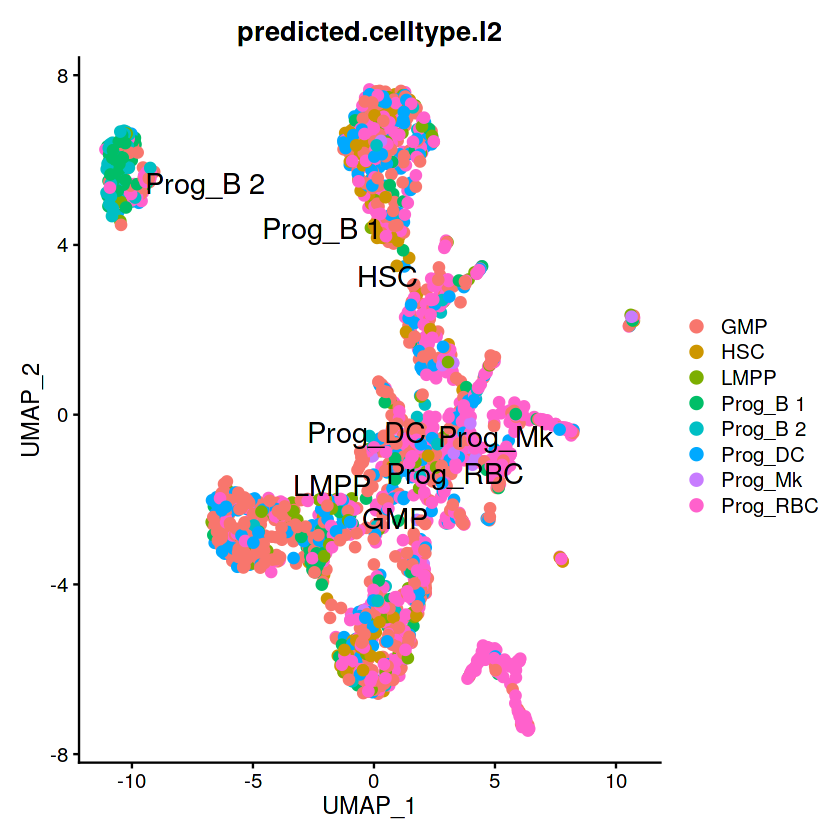

In [64]:
predicted_umap_plot  <- DimPlot(bm_filt, reduction = "umap", group.by = "predicted.celltype.l2", label = TRUE, label.size = 6 ,repel = TRUE, pt.size = 2.5)
predicted_umap_plot

In [65]:
ggsave(filename = paste(figures_dir , "predicted_umap.png", sep=''),predicted_umap_plot)

Saving 6.67 x 6.67 in image



In [66]:
predicted_umap_plot_aug <- AugmentPlot(plot = predicted_umap_plot, dpi=500)

In [67]:
ggsave(filename = paste(figures_dir , "predicted_umap_aug.png", sep=''),predicted_umap_plot_aug)

Saving 6.67 x 6.67 in image



In [68]:
real_id_plot <- DimPlot(bm_filt, reduction = "umap", group.by = "orig.ident", label = TRUE, label.size = 6 ,repel = TRUE, pt.size = 2.5)
real_id_plot_aug <-AugmentPlot(real_id_plot, width = 10, height = 10, dpi = 500)
ggsave(filename = paste(figures_dir , "real_id_plot_aug.png", sep=''),real_id_plot_aug)

Saving 6.67 x 6.67 in image



In [69]:
# save lenged separately
real_id_plot_w_legend <- DimPlot(bm_filt, reduction = "umap", group.by = "orig.ident", label = TRUE, label.size = 6 ,repel = TRUE, pt.size = 2.5) +  guides(color = guide_legend(override.aes = list(size=7), ncol=3) )

# Extract the legend. Returns a gtable
leg <- get_legend(real_id_plot_w_legend)

# Convert to a ggplot and print
save_plot(leg,filename = paste(figures_dir ,  "real_id_plot_legend.png", sep=''), dpi = 600)

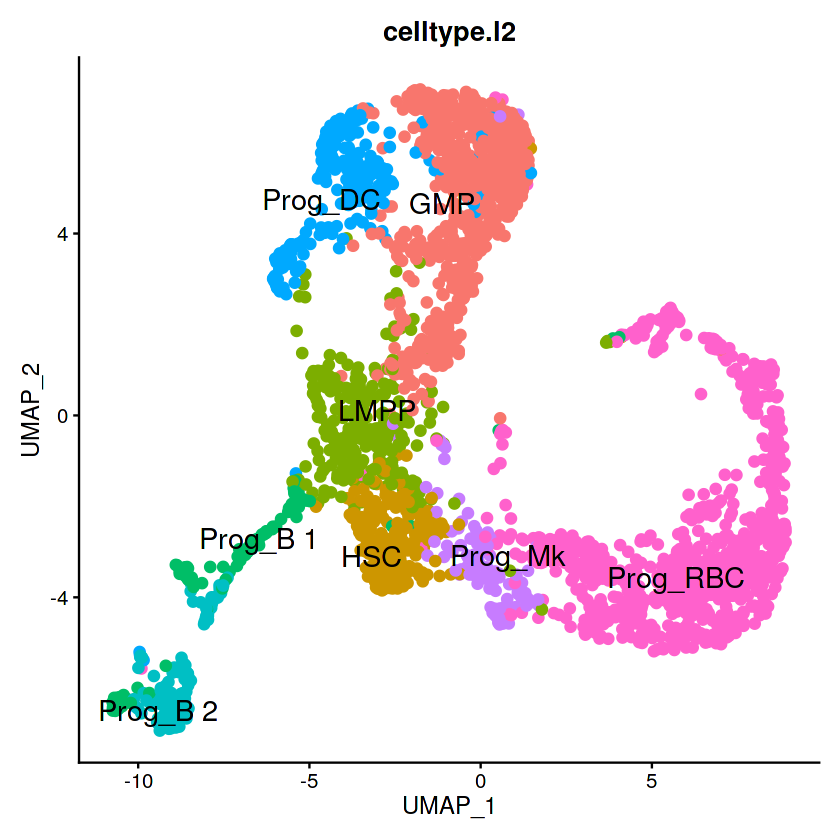

In [70]:
DimPlot(bm_ref_ony_progenitor, reduction = 'umap', group.by = 'celltype.l2', label = TRUE, label.size = 6,repel = TRUE, pt.size = 2.5) + NoLegend()


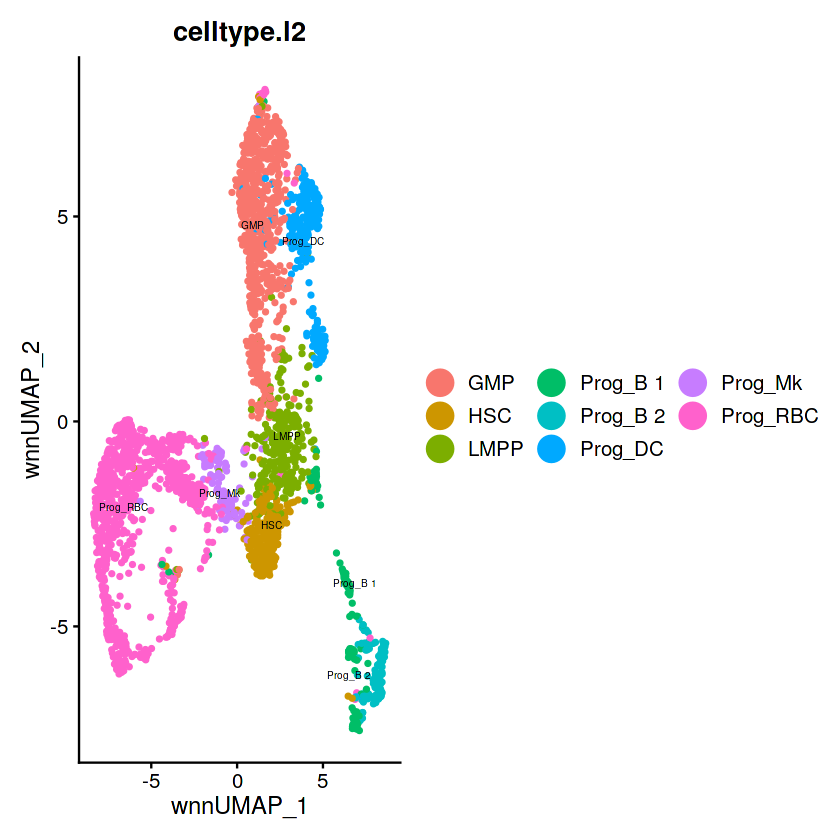

In [71]:
reference_bm_plot <- DimPlot(bm_ref_ony_progenitor, reduction = 'wnn.umap', group.by = 'celltype.l2', label = TRUE, label.size = 2,repel = TRUE, pt.size = 1)+  guides(color = guide_legend(override.aes = list(size=7), ncol=3) )
reference_bm_plot

In [72]:
# Extract the legend. Returns a gtable
leg <- get_legend(reference_bm_plot)
# Convert to a ggplot and print
save_plot(leg, filename = paste(figures_dir ,  "reference_bm_plot_aug_legend.png"), dpi = 600)
          

In [73]:
reference_bm_plot <- DimPlot(bm_ref_ony_progenitor, reduction = 'wnn.umap', group.by = 'celltype.l2', label = TRUE, label.size = 6,repel = TRUE, pt.size = 2.5) + NoLegend()
reference_bm_plot_aug <-AugmentPlot(reference_bm_plot, width = 10, height = 10, dpi = 500)
ggsave(filename =  paste(figures_dir , "reference_bm_plot_aug.png"),reference_bm_plot_aug)

Saving 6.67 x 6.67 in image



In [74]:
reference_bm_plot <- DimPlot(bm_ref_ony_progenitor, reduction = 'umap', group.by = 'celltype.l2', label = TRUE, label.size = 7,repel = TRUE, pt.size = 2.5) + NoLegend()
reference_bm_plot_aug <-AugmentPlot(reference_bm_plot, width = 10, height = 10, dpi = 500)
ggsave(filename =  paste(figures_dir , "reference_bm_umap_plot_aug.png"),reference_bm_plot_aug)

Saving 6.67 x 6.67 in image



## export the annotations

In [76]:
write.csv(bm_filt@meta.data, "../../../results/Fig1_Fig2_Fig3_SFig1-FACS_BM_scATAC/Fig3-apply_seurat_label_transfer/buenrostro2018_Seurat4_labeltransfer_bm_ref_ony_progenitor_metadata.csv",row.names = T)